In [47]:
import os
import time
import timeit

import cv2
import imutils
import numpy as np
from PIL import Image, ImageChops
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity
import random as rng
import inspect

%matplotlib inline

In [48]:
def display(img,cmap='gray'):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.title.set_text(retrieve_name(img))
    ax.imshow(img,cmap='gray')
    


def retrieve_name(var):
        """
        Gets the name of var. Does it from the out most frame inner-wards.
        :param var: variable to get name from.
        :return: string
        """
        for fi in reversed(inspect.stack()):
            names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
            if len(names) > 0:
                return names[0]

In [49]:
def get_intersect(a1, a2, b1, b2):
    """ 
    source: https://stackoverflow.com/questions/3252194/numpy-and-line-intersections
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)


In [65]:
class adMatay:
    room_frame1 = r'samples/test_diff/ch12_f1.png' #image file path
    room_frame2 = r'samples/test_diff/ch12_f2.png' #image file path
    mask_np_array=None # numpy array
    mask_contours=None # ndarray
    mask_img=None # cv2
    
    top_right_intersection=None
    top_left_intersection=None
    bottom_right_intersection=None
    bottom_left_intersection=None
    
    
    def get_corners(self, np_image):
        # Find the top, bottom, left , and right.
        # Then make sure they are in tuple format
        top1    = tuple(np_image[np_image[:, :, 1].argmin()][0])
        top2    =tuple(np_image[np_image[:, :, 1].argmin()][1])
        
        bottom1 = tuple(np_image[np_image[:, :, 1].argmax()][0])
        bottom2 = tuple(np_image[np_image[:, :, 1].argmax()][1])

        left1   = tuple(np_image[np_image[:, :, 0].argmin()][0])
        left2   = tuple(np_image[np_image[:, :, 0].argmin()][1])

        right1  = tuple(np_image[np_image[:, :, 0].argmax()][0])
        right2  = tuple(np_image[np_image[:, :, 0].argmax()][1])
        
        self.top_right_intersection=get_intersect(top1,top2,right1,right2)
        self.top_left_intersection=get_intersect(top1,top2,left1,left2)
        self.bottom_right_intersection=get_intersect(bottom,bottom2,right1,right2)
        self.bottom_left_intersection=get_intersect(bottom,bottom2,left1,left2)
        return
    
    
    
    # take 2 frames and returns a mask of the diff
    def get_diff_frames(self):
        frame1 = cv2.imread(self.room_frame1)
        frame2 = cv2.imread(self.room_frame2)
        # Convert images to grayscale
        before_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        after_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        
        # Compute SSIM between two images
        (score, diff) = structural_similarity(before_gray, after_gray, full=True, gaussian_weights=True, sigma=2.5, use_sample_covariance=False, data_range=255)
        print("Image similarity", score)    
        

        # The diff image contains the actual image differences between the two images
        # and is represented as a floating point data type in the range [0,1]
        # so we must convert the array to 8-bit unsigned integers in the range
        # [0,255] before we can use it with OpenCV
        diff = (diff * 255).astype("uint8")
        
        # Threshold the difference image, followed by finding contours to
        # obtain the regions of the two input images that differ
        thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        cnts=contours
        contours = contours[0] if len(contours) == 2 else contours[1]
        mask = np.zeros(frame1.shape, dtype='uint8')
        print(type(mask))
        self.mask_contours=contours.copy()
        frame_roi_cv2 = np.array(mask)
        frame_roi_cv2 = frame_roi_cv2[:, :, ::-1].copy()
        self.mask_img=frame_roi_cv2
        self.mask_np_array=mask.copy()
        
        c = max(contours, key = cv2.contourArea)
        x,y,w,h = cv2.boundingRect(c)
        print(x,y,w,h)
        cv2.drawContours(mask, [c], 0, (0,255,10), -1)
        #cv2.rectangle(mask,(x,y),(x+w,y+h),(155,0,155),1)

#         display(frame1)
#         display(frame2)
        display(mask)
    
        self.get_corners(mask)
        cv2.circle(img=mask, center = top_right_intersection, radius =5, color =(100,100,100), thickness=-1)
        cv2.circle(img=mask, center = top_left_intersection, radius =5, color =(100,100,100), thickness=-1)
        cv2.circle(img=mask, center = bottom_right_intersection, radius =5, color =(100,100,100), thickness=-1)
        cv2.circle(img=mask, center = bottom_left_intersection, radius =5, color =(100,100,100), thickness=-1)

        
    
    ## above works

        mask2=mask.copy()

        # Getting the biggest contour
        if len(contours) != 0:
            # draw in blue the contours that were founded
            cv2.drawContours(mask2, contours, -1, 255, 2)

            # find the biggest countour (c) by the area
            c = max(contours, key = cv2.contourArea)
            x2,y2,w2,h2 = cv2.boundingRect(c)
        
        cv2.circle(img=mask2, center = (x2,y2), radius =5, color =(100,0,100), thickness=-1)
#         cv2.putText(mask2,"1",(x,y),cv2.FONT_HERSHEY_COMPLEX,3,(250,250,10),2)

        cv2.circle(img=mask2, center = (x2+w2,y2+h2), radius =5, color =(255,0,100), thickness=-1)
#         cv2.putText(mask2,"2",(x+w,y+h),cv2.FONT_HERSHEY_COMPLEX,3,(250,250,10),2)

        cv2.circle(img=mask2, center = (x2+w2,y2), radius =5, color =(255,0,100), thickness=-1)
#         cv2.putText(mask2,"3",(x+w,y),cv2.FONT_HERSHEY_COMPLEX,3,(250,250,10),2)

        cv2.circle(img=mask2, center = (x2, y2+h2), radius =5, color =(255,0,100), thickness=-1)
#         cv2.putText(mask2,"4",(x,y+h),cv2.FONT_HERSHEY_COMPLEX,3,(250,250,10),2)
        display(mask2)
        
        
        
        # Draw contours + hull results
        drawing = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for i in range(len(contours)):
            color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
            cv2.drawContours(drawing, contours, i, color)
        # Show in a window
        display(drawing)

#####

        cv2.circle(img=mask, center = (x,y), radius =5, color =(100,0,100), thickness=-1)
        cv2.putText(mask,"1",(x,y),cv2.FONT_HERSHEY_COMPLEX,3,(250,250,10),2)

        cv2.circle(img=mask, center = (x+w,y+h), radius =5, color =(255,0,100), thickness=-1)
        cv2.putText(mask,"2",(x+w,y+h),cv2.FONT_HERSHEY_COMPLEX,3,(250,250,10),2)

        cv2.circle(img=mask, center = (x+w,y), radius =5, color =(255,0,100), thickness=-1)
        cv2.putText(mask,"3",(x+w,y),cv2.FONT_HERSHEY_COMPLEX,3,(250,250,10),2)

        cv2.circle(img=mask, center = (x, y+h), radius =5, color =(255,0,100), thickness=-1)
        cv2.putText(mask,"4",(x,y+h),cv2.FONT_HERSHEY_COMPLEX,3,(250,250,10),2)
        display(mask)
        plt.imshow(mask)      
        
        print(x,y)
        print(x+w,y+h)
        print(x+w,y)
        print(x,y+h)

        
    def get_tv_corners(self):
        pass
    
    tv_corner_top_right=0
    tv_corner_top_left=0
    tv_corner_bottom_left=0
    tv_corner_bottom_right=0
    
    def affine_trans(self):
        pass
    
    tv_top_strip=0
    tv_top_right_corner=0
    tv_top_left_corner=0
    
    currently_commercial=0
    
    # get 2 extreme points of each axis,
    # makes a line segment out of them,
    # finds the intersection of each 2 neghibors as a corner
    




    

Image similarity 0.8268132839466079
<class 'numpy.ndarray'>
278 160 487 247


IndexError: index 205082 is out of bounds for axis 0 with size 720

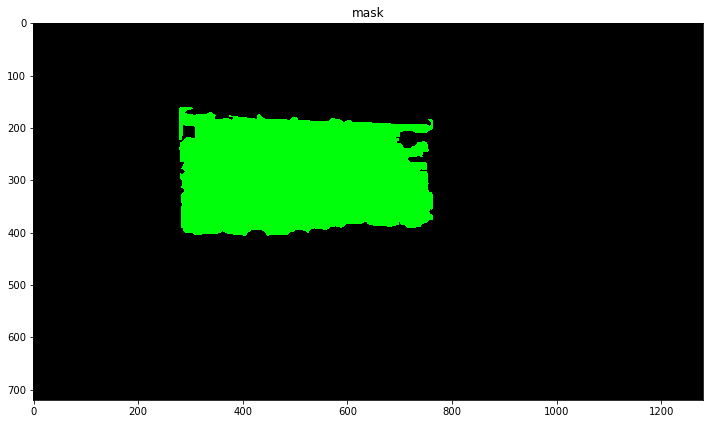

In [66]:
test= adMatay()
test.get_diff_frames()

In [ ]:
def segment(frame, threshold=25):
    
    # Calculates the Absolute Differentce between the backgroud and the passed in frame
#     diff = cv2.absdiff(background.astype("uint8"), frame)

    # Apply a threshold to the image so we can grab the foreground
    # We only need the threshold, so we will throw away the first item in the tuple with an underscore _
#     _ , thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)
    
    # Grab the external contours form the image
    # Again, only grabbing what we need here and throwing away the rest
    #image, contours, hierarchy = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours=test.mask_contours
    
    # If length of contours list is 0, then we didn't grab any contours!
    if len(contours) == 0:
        return None
    else:
        # Given the way we are using the program, the largest external contour should be the hand (largest by area)
        # This will be our segment
        hand_segment = max(contours, key=cv2.contourArea)
        
        # Return both the hand segment and the thresholded hand image
        return hand_segment


In [23]:
def count_fingers(thresholded, hand_segment):
    
    
    # Calculated the convex hull of the hand segment
    conv_hull = cv2.convexHull(hand_segment)
    
    # Now the convex hull will have at least 4 most outward points, on the top, bottom, left, and right.
    # Let's grab those points by using argmin and argmax. Keep in mind, this would require reading the documentation
    # And understanding the general array shape returned by the conv hull.

    # Find the top, bottom, left , and right.
    # Then make sure they are in tuple format
    top    = tuple(conv_hull[conv_hull[:, :, 1].argmin()][0])
    bottom = tuple(conv_hull[conv_hull[:, :, 1].argmax()][0])
    left   = tuple(conv_hull[conv_hull[:, :, 0].argmin()][0])
    right  = tuple(conv_hull[conv_hull[:, :, 0].argmax()][0])

    # In theory, the center of the hand is half way between the top and bottom and halfway between left and right
    cX = (left[0] + right[0]) // 2
    cY = (top[1] + bottom[1]) // 2

    # find the maximum euclidean distance between the center of the palm
    # and the most extreme points of the convex hull
    
    # Calculate the Euclidean Distance between the center of the hand and the left, right, top, and bottom.
    distance = pairwise.euclidean_distances([(cX, cY)], Y=[left, right, top, bottom])[0]
    
    # Grab the largest distance
    max_distance = distance.max()
    
    # Create a circle with 90% radius of the max euclidean distance
    radius = int(0.8 * max_distance)
    circumference = (2 * np.pi * radius)

    # Not grab an ROI of only that circle
    circular_roi = np.zeros(thresholded.shape[:2], dtype="uint8")
    
    # draw the circular ROI
    cv2.circle(circular_roi, (cX, cY), radius, 255, 10)
    
    
    # Using bit-wise AND with the cirle ROI as a mask.
    # This then returns the cut out obtained using the mask on the thresholded hand image.
#     circular_roi = cv2.bitwise_and(thresholded, thresholded, mask=circular_roi)

    # Grab contours in circle ROI
#     image, contours, hierarchy = cv2.findContours(circular_roi.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours=test.mask_contours

    # Finger count starts at 0
    count = 0
    
#     frame=test.mask_img.copy()
    
    # loop through the contours to see if we count any more fingers.
    for cnt in contours:
        
        # Bounding box of countour
        (x, y, w, h) = cv2.boundingRect(cnt)

        # Increment count of fingers based on two conditions:
        
        # 1. Contour region is not the very bottom of hand area (the wrist)
#         out_of_wrist = ((cY + (cY * 0.25)) > (y + h))
        
        # 2. Number of points along the contour does not exceed 25% of the circumference of the circular ROI (otherwise we're counting points off the hand)
        limit_points = ((circumference * 0.25) < cnt.shape[0])
        
        cv2.circle(frame, (x, y), radius =5, color =(255,0,100), thickness=-1)


#         if  out_of_wrist and limit_points:
        count += 1
    display(frame)
    return count


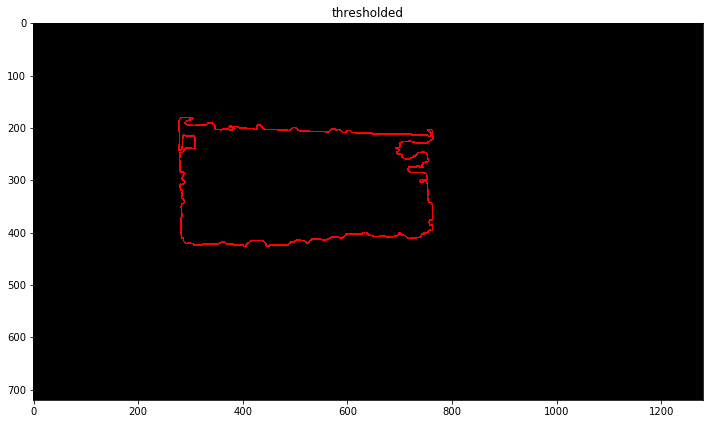

In [24]:
from sklearn.metrics import pairwise


accumulated_weight = 0.5


# Manually set up our ROI for grabbing the hand.
# Feel free to change these. I just chose the top right corner for filming.
roi_top = 20
roi_bottom = test.mask_img.shape[0]
roi_right = 0
roi_left = test.mask_img.shape[1]


# segment the hand region
hand = segment(test.mask_img)
# First check if we were able to actually detect a hand
frame_copy=test.mask_img.copy()
if hand is not None:

    # unpack
    thresholded = test.mask_img.copy()
    hand_segment = hand

    # Draw contours around hand segment
    cv2.drawContours(thresholded, [hand_segment + (roi_right, roi_top)], -1, (255, 0, 0),2)

    # Count the fingers
#     fingers = count_fingers(thresholded, segment(thresholded))

    # Display count
#     cv2.putText(frame_copy, str(fingers), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    # Also display the thresholded image
    display(thresholded)
    cv2.imwrite('process_results/thresholded.png', thresholded)



contours: 1280
largest contour has  1280 points


TypeError: curve is not a numpy array, neither a scalar

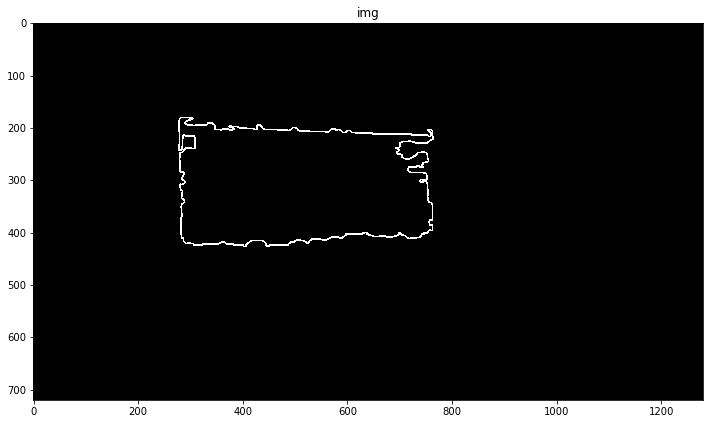

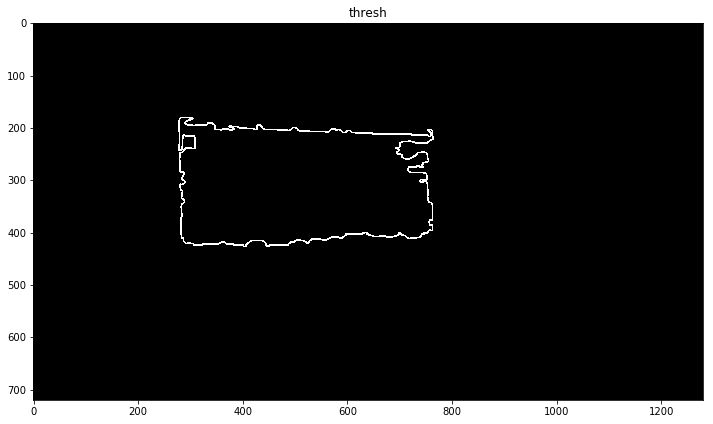

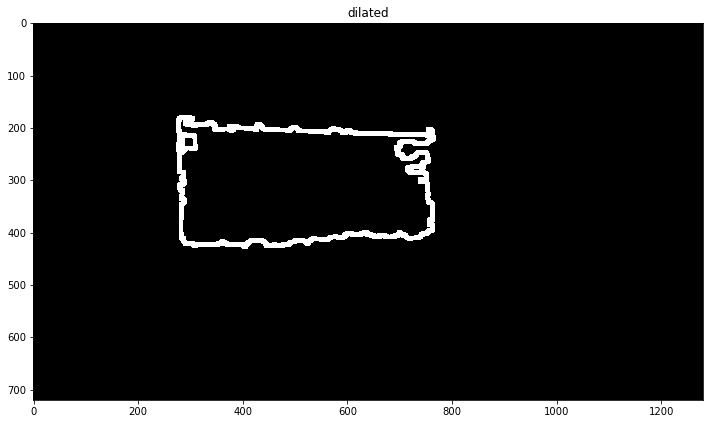

In [41]:
# threshold image
img=cv2.imread('process_results/thresholded.png',0)
display(img)
# threshold image
ret,thresh = cv2.threshold(img,0,255,0)
display(thresh)
# dilate thresholded image - merges top/bottom 
kernel = np.ones((3,3), np.uint8)
dilated = cv2.dilate(thresh, kernel, iterations=3)
#cv2.imshow('threshold dilated',dilated)
display(dilated)

# find contours
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
contours = contours[0] if imutils.is_cv2() else contours[1]
# contours_ = contours[0] if imutils.is_cv2() else contours[1]

# cv2.drawContours(img, contours, 0, (255,255,255), 3)
print ("contours:",len(contours))
print ("largest contour has ",len(contours),"points")

gray_image = cv2.convertScaleAbs(thresh)
# simplify contours
# epsilon = 0.1*cv2.arcLength(gray_image,True)
# approx = cv2.approxPolyDP(contours,epsilon,True)
simplified=img.copy()
# cv2.drawContours(simplified, [approx], 0, (255,255,255), 2)
# print ("simplified contour has",len(approx),"points ", epsilon)

for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    cv2.drawContours(simplified, [approx], 0, (255,255,255), 2)

display(simplified)


In [1]:
def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

[[[444 717]]

 [[444 719]]

 [[447 719]]

 [[446 717]]] 0.9414213538169861
simplified contour has 4 points
[[[447 719]]

 [[444 719]]

 [[444 717]]

 [[446 717]]

 [[447 718]]]


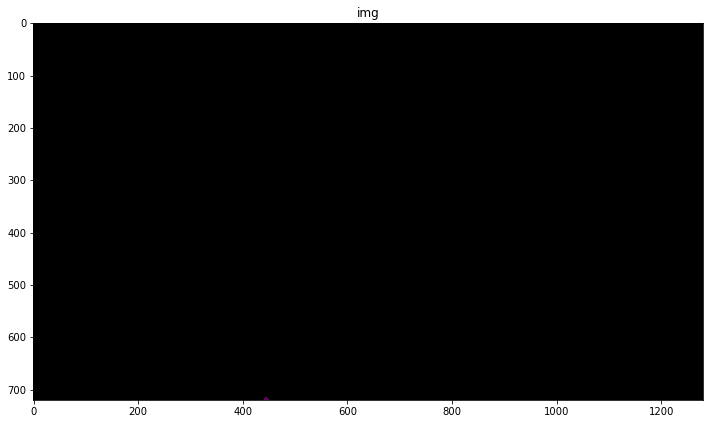

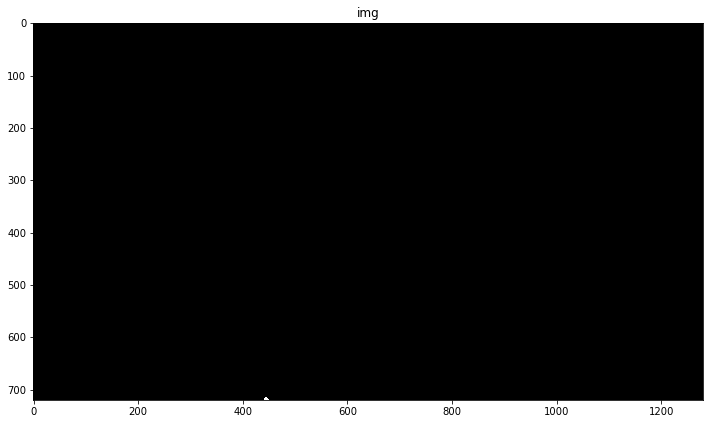

In [14]:
contours=test.mask_contours
img=test.mask_img.copy()
hull = cv2.convexHull(contours[0])
cv2.drawContours(img, [hull], 0, (100,0,100), 3)
display(img)
epsilon = 0.1*cv2.arcLength(contours[0],True)
approx = cv2.approxPolyDP(contours[0],epsilon,True)
cv2.drawContours(img, [approx], 0, (255,255,255), 3)
display(img)
print(approx, epsilon)
print ("simplified contour has",len(approx),"points")
# display output 
cv2.circle(img, center =(444, 717), radius =10,  color =(100,100,100), thickness=-1)
# cv2.putText(mask,"1",(x,y),cv2.FONT_HERSHEY_COMPLEX,3,(250,250,10),2)

cv2.circle(img,(444, 719), radius =10, color =(100,100,100), thickness=-1)
# cv2.putText(mask,"2",(x+w,y+h),cv2.FONT_HERSHEY_COMPLEX,3,(250,250,10),2)

cv2.circle(img, (447, 719), radius =10,  color =(100,100,100), thickness=-1)
# cv2.putText(mask,"3",(x+w,y),cv2.FONT_HERSHEY_COMPLEX,3,(250,250,10),2)

cv2.circle(img, (446, 717), radius =10, color =(100,100,100), thickness=-1)


print(hull)

In [98]:
minimum_bounding_rectangle(points)

array([[765., 160.],
       [278., 160.],
       [278., 407.],
       [765., 407.]])

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(points[:,0], points[:,1])
bbox = minimum_bounding_rectangle(points)
plt.fill(bbox[:,0], bbox[:,1], alpha=0.2)
plt.axis('equal')
plt.show()


mask=test.mask_img
cv2.circle(img=mask, center = tuple(points[0]), radius =10, color =(0,200,0), thickness=-1)
# cv2.putText(mask,"1",(x,y),cv2.FONT_HERSHEY_COMPLEX,3,(250,250,10),2)

cv2.circle(img=mask, center = tuple(points[1]), radius =10, color =(0,200,0), thickness=-1)
# cv2.putText(mask,"2",(x+w,y+h),cv2.FONT_HERSHEY_COMPLEX,3,(250,250,10),2)

cv2.circle(img=mask, center = tuple(points[2]), radius =10, color =(0,200,0), thickness=-1)
# cv2.putText(mask,"3",(x+w,y),cv2.FONT_HERSHEY_COMPLEX,3,(250,250,10),2)

cv2.circle(img=mask, center = tuple(points[3]), radius =10, color =(0,200,0), thickness=-1)
# cv2.putText(mask,"4",(x,y+h),cv2.FONT_HERSHEY_COMPLEX,3,(250,250,10),2)
display(mask)